In [1]:
import numpy as np
import lsst.sims.featureScheduler as fs
from lsst.sims.speedObservatory import Speed_observatory
import matplotlib.pylab as plt
import healpy as hp
from lsst.sims.utils import _hpid2RaDec
import time

t0 = time.time()

/Users/yoachim/gitRepos/sims_featureScheduler/python/lsst/sims/featureScheduler/utils.py:27: UserWarning: Could not import ts.scheduler. This is required to load the FieldsDatabase. In this case
it will fallback to loading fields from the local "fieldID.lis" file.
  it will fallback to loading fields from the local "fieldID.lis" file.''')


In [2]:
# Get rid of the silly north stripe
def standard_goals(nside=None):
    """
    A quick function to generate the "standard" goal maps.
    """
    # Find the number of healpixels we expect to observe per observation
    if nside is None:
        nside = fs.set_default_nside()

    result = {}
    result['u'] = fs.generate_goal_map(nside=nside, NES_fraction=0.,
                                    WFD_fraction=0.31, SCP_fraction=0.15,
                                    GP_fraction=0.15, WFD_upper_edge_fraction=0.)
    result['g'] = fs.generate_goal_map(nside=nside, NES_fraction=0.2,
                                    WFD_fraction=0.44, SCP_fraction=0.15,
                                    GP_fraction=0.15, WFD_upper_edge_fraction=0.)
    result['r'] = fs.generate_goal_map(nside=nside, NES_fraction=0.46,
                                    WFD_fraction=1.0, SCP_fraction=0.15,
                                    GP_fraction=0.15, WFD_upper_edge_fraction=0.)
    result['i'] = fs.generate_goal_map(nside=nside, NES_fraction=0.46,
                                    WFD_fraction=1.0, SCP_fraction=0.15,
                                    GP_fraction=0.15, WFD_upper_edge_fraction=0.)
    result['z'] = fs.generate_goal_map(nside=nside, NES_fraction=0.4,
                                    WFD_fraction=0.9, SCP_fraction=0.15,
                                    GP_fraction=0.15, WFD_upper_edge_fraction=0.)
    result['y'] = fs.generate_goal_map(nside=nside, NES_fraction=0.,
                                       WFD_fraction=0.9, SCP_fraction=0.15,
                                       GP_fraction=0.15,
                                       WFD_upper_edge_fraction=0.)

    return result

In [3]:
nside = fs.set_default_nside(nside=32)


# Let's set up some alt_az maps
# XXX--this is an initial guess at what reasoable blocks might look like! 
alt_az_blockmaps = []
hpids = np.arange(hp.nside2npix(nside))
az, alt = _hpid2RaDec(nside, hpids)

# XXX--seem like reasonable numbers, but who knows if they are hte best!
alt_low_limit = np.radians(20.)
alt_high_limit = np.radians(82.)
az_half_width = np.radians(15.)

blank_map = hpids *0.
good = np.where( ((az > 2.*np.pi-az_half_width) | (az < az_half_width)) &
                (alt > alt_low_limit) & (alt < alt_high_limit))
new_map = blank_map +0
new_map[good] = 1
alt_az_blockmaps.append(new_map)

good = np.where(((az > np.pi-az_half_width) & (az < np.pi+az_half_width)) &
                (alt > alt_low_limit) & (alt < alt_high_limit))
new_map = blank_map +0
new_map[good] = 1
alt_az_blockmaps.append(new_map)

# let's make some finer grained steps. Bring up the lower limit a bit.
alt_high_limit = np.radians(75.)
alt_low_limit = np.radians(35.)

steps = np.arange(20, 330, 20)
for step in steps:
    good = np.where((az > np.radians(step)) & (az < np.radians(step)+az_half_width*2) & 
                   (alt > alt_low_limit) & (alt < alt_high_limit))
    new_map = blank_map +0
    new_map[good] = 1
    alt_az_blockmaps.append(new_map)


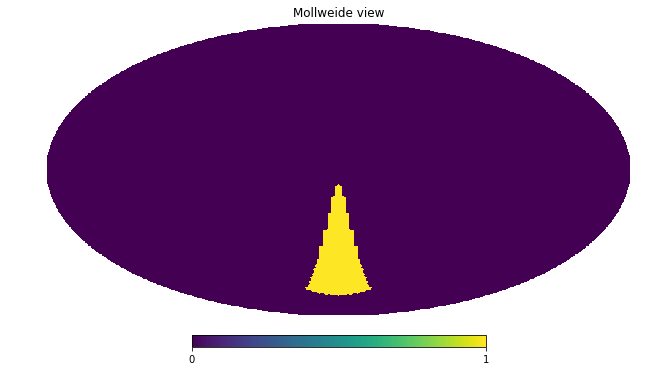

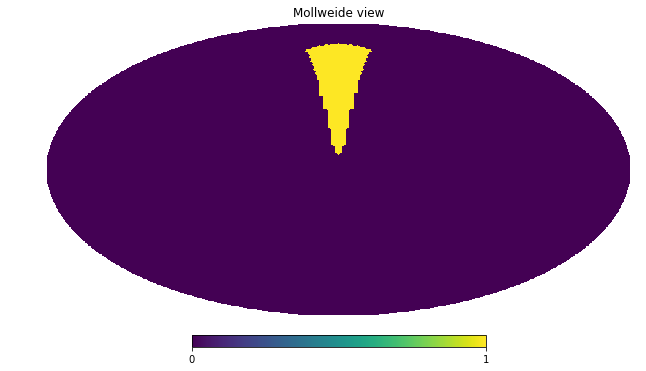

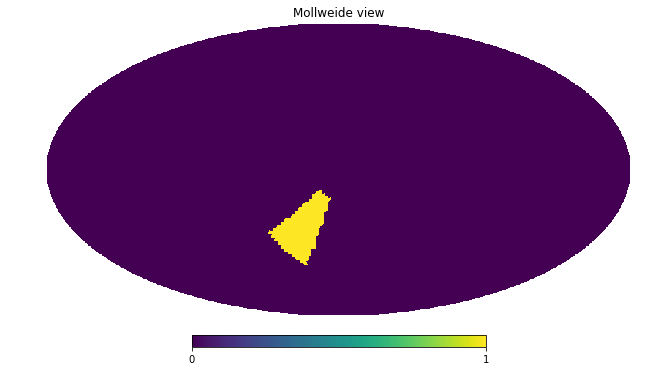

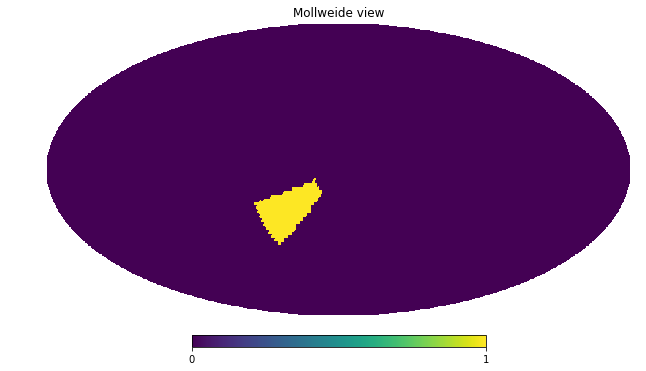

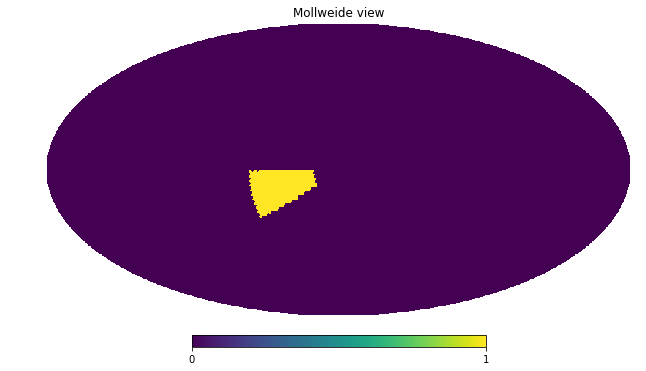

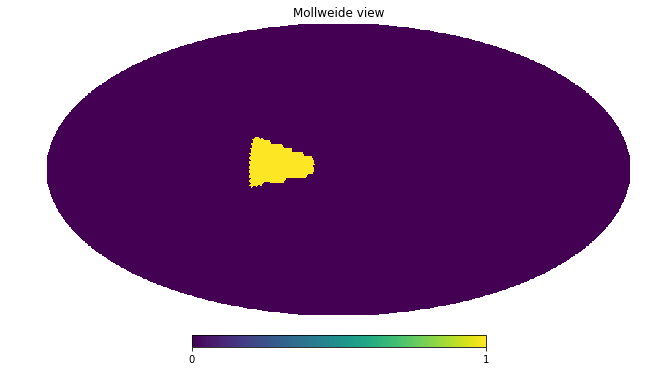

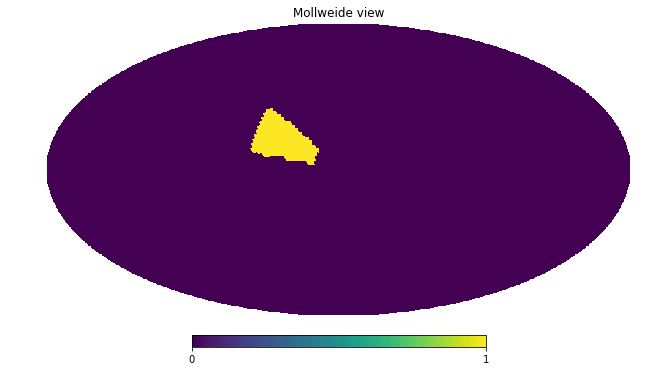

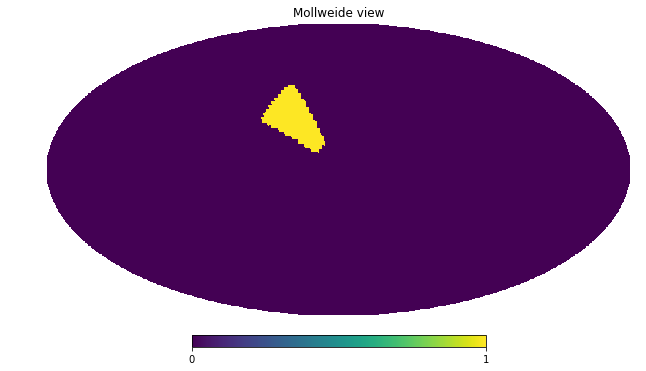

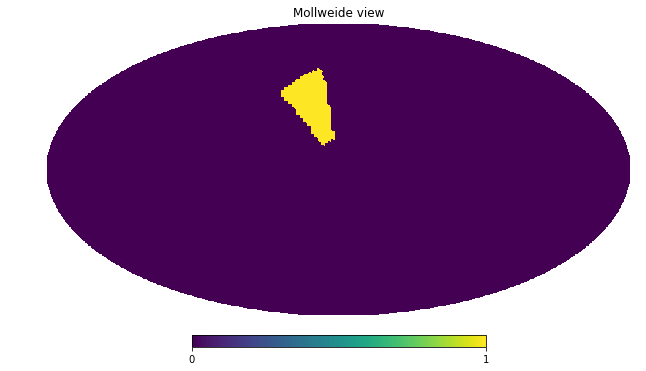

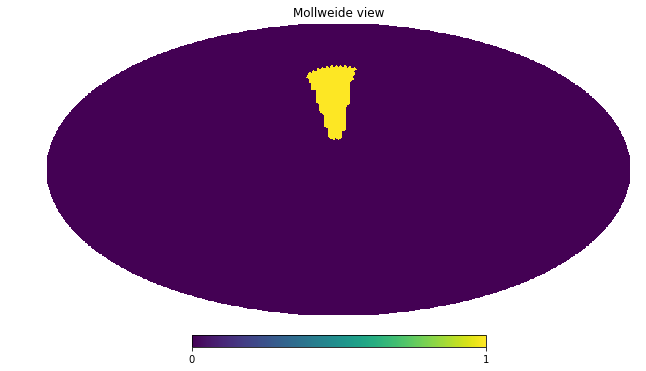

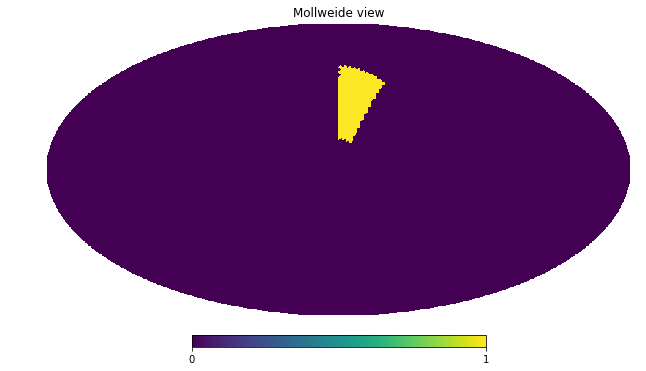

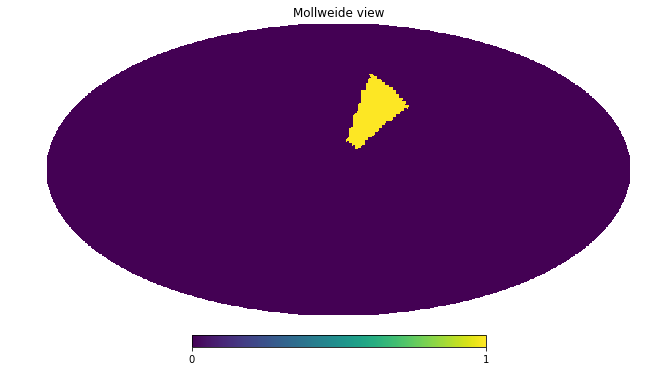

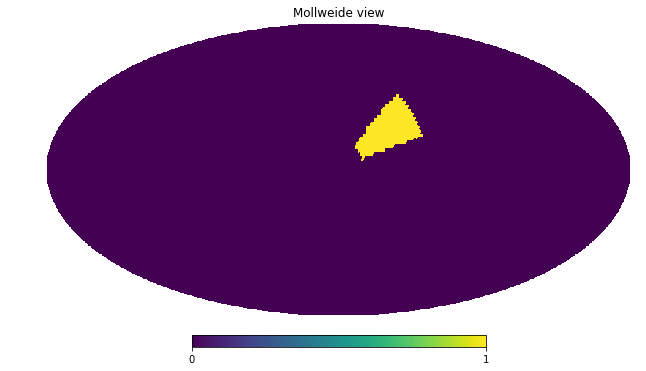

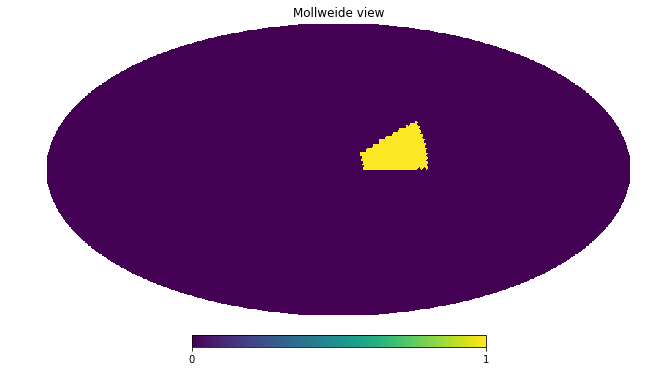

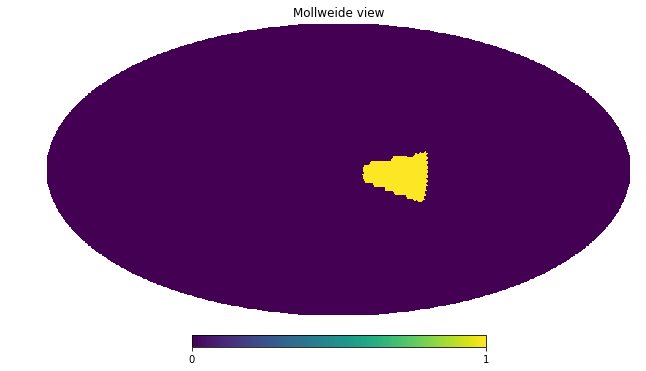

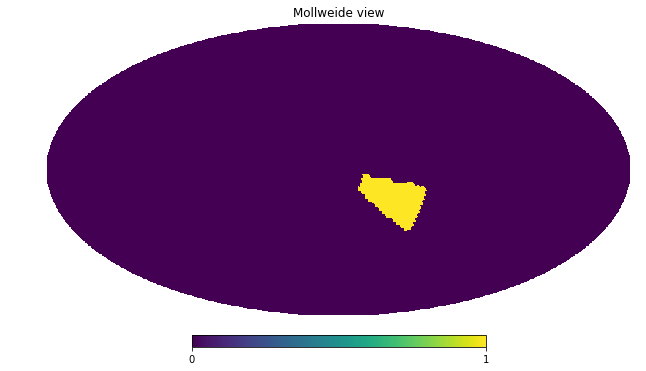

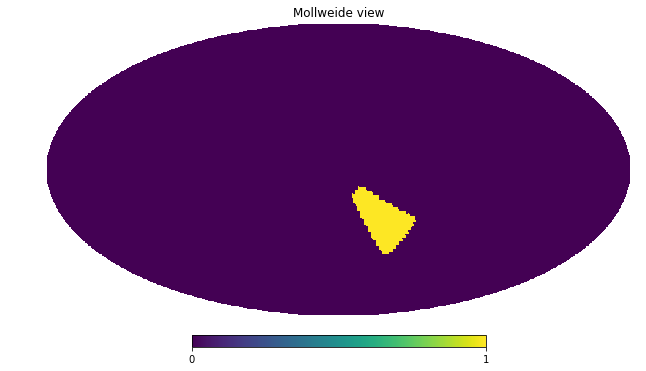

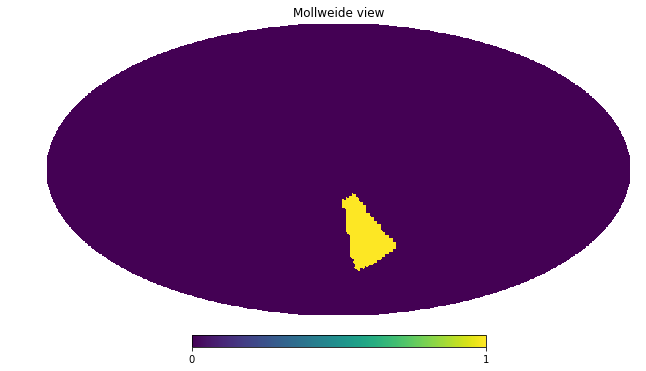

In [4]:
# Let's see what my masks look like
for aamap in alt_az_blockmaps:
    hp.mollview(aamap, rot=(0,90))

In [5]:
survey_length = 366 #365.25*10  # days

# Define what we want the final visit ratio map to look like
years = np.round(survey_length/365.25)
# get rid of silly northern strip.
target_map = standard_goals(nside=nside)

# List to hold all the surveys (for easy plotting later)
surveys = []

# Set up observations to be taken in blocks
filter1s = ['u', 'g', 'r', 'i', 'y']
filter2s = [None, 'r', 'i', 'z', None]
pair_surveys = []
for filtername, filtername2 in zip(filter1s, filter2s):
    bfs = []
    bfs.append(fs.M5_diff_basis_function(filtername=filtername, nside=nside))
    if filtername2 is not None:
        bfs.append(fs.M5_diff_basis_function(filtername=filtername2, nside=nside))
    bfs.append(fs.Target_map_basis_function(filtername=filtername,
                                            target_map=target_map[filtername],
                                            out_of_bounds_val=hp.UNSEEN, nside=nside))
    if filtername2 is not None:
        bfs.append(fs.Target_map_basis_function(filtername=filtername2,
                                            target_map=target_map[filtername2],
                                            out_of_bounds_val=hp.UNSEEN, nside=nside))
    bfs.append(fs.Slewtime_basis_function(filtername=filtername, nside=nside))
    # XXX--put a huge boost on staying in the filter. Until I can tier surveys as list-of-lists
    weights = np.array([3.0, 3.0, 0.3, 0.3, 3.])
    if filtername2 is None:
        # Need to scale weights up so filter balancing still works. 
        weights = np.array([6.0, 0.6, 3.])
    # XXX-
    # This is where we could add a look-ahead basis function to include m5_diff in the future.
    # Actually, having a near-future m5 would also help prevent switching to u or g right at twilight?
    # Maybe just need a "filter future" basis function? 
    if filtername2 is None:
        survey_name = 'block, %s' % filtername
    else:
        survey_name = 'block, %s%s' % (filtername, filtername2)
    surveys.append(fs.Block_survey(bfs, weights, filtername=filtername, filter2=filtername2,
                                   dither=True, nside=nside, ignore_obs='DD',
                                   alt_az_masks=alt_az_blockmaps,
                                   survey_note=survey_name))
    pair_surveys.append(surveys[-1])


# Let's set up some standard surveys as well to fill in the gaps. This is my old silly masked version.
# It would be good to put in Tiago's verion and lift nearly all the masking. That way this can also
# chase sucker holes.
filters = ['u','g', 'r','i', 'z', 'y']
greedy_surveys = []
for filtername in filters:
    bfs = []
    bfs.append(fs.M5_diff_basis_function(filtername=filtername, nside=nside))
    bfs.append(fs.Target_map_basis_function(filtername=filtername,
                                            target_map=target_map[filtername],
                                            out_of_bounds_val=hp.UNSEEN, nside=nside))

    bfs.append(fs.North_south_patch_basis_function(zenith_min_alt=50., nside=nside))
    bfs.append(fs.Slewtime_basis_function(filtername=filtername, nside=nside))
    bfs.append(fs.Strict_filter_basis_function(filtername=filtername))

    weights = np.array([3.0, 0.3, 1., 3., 3.])
    # Might want to try ignoring DD observations here, so the DD area gets covered normally--DONE
    surveys.append(fs.Greedy_survey_fields(bfs, weights, block_size=1, filtername=filtername,
                                           dither=True, nside=nside, ignore_obs='DD'))
    greedy_surveys.append(surveys[-1])

# Set up the DD surveys
#dd_surveys = []
dd_surveys = fs.generate_dd_surveys()
surveys.extend(dd_surveys)


survey_list_o_lists = [pair_surveys, greedy_surveys]
#survey_list_o_lists = [dd_surveys, pair_surveys, greedy_surveys]

In [6]:
# Debug to stop at a spot if needed
n_visit_limit = None

# put in as list-of-lists so pairs get evaluated first.
scheduler = fs.Core_scheduler(survey_list_o_lists, nside=nside)
observatory = Speed_observatory(nside=nside, quickTest=True)
observatory, scheduler, observations = fs.sim_runner(observatory, scheduler,
                                                     survey_length=survey_length,
                                                     filename='blocks_%iyrs.db' % years,
                                                     delete_past=True, n_visit_limit=n_visit_limit)

/Users/yoachim/gitRepos/sims_seeingModel/python/lsst/sims/seeingModel/seeingModel.py:133: RuntimeWarning: invalid value encountered in power
  airmass_correction = np.power(airmass, 0.6)


progress = 1.7%

KeyboardInterrupt: 

In [ ]:
hp.mollview(surveys[0].basis_functions[0]())

In [ ]:
hp.mollview(surveys[0].basis_functions[1]())

In [ ]:
# The poor man's hourglass plot.
filter2color = {'u': 'purple', 'g': 'blue', 'r': 'green',
                             'i': 'cyan', 'z': 'orange', 'y': 'red'}
color_convert = [filter2color[filtername] for filtername in observations['filter']]
plt.scatter(observations['mjd'], observations['sunAlt'], c=color_convert, alpha=.4)
plt.xlabel('MJD')
plt.ylabel('sun altitude')
#plt.xlim([observations['mjd'].min()+1, observations['mjd'].min()+5.4])
#plt.xlim([59695, 59710])

In [ ]:
reward = surveys[0].calc_reward_function()
if np.size(reward) > 1:
    hp.mollview(reward, title='block reward, max=%.2f' % reward.max())

In [ ]:
for survey in surveys[1:-len(dd_surveys)]:
    rw = survey.calc_reward_function()
    if np.size(rw) > 1:
        hp.mollview(survey.calc_reward_function(), title=survey.filtername)


In [ ]:
plt.scatter(observations['mjd'], observations['slewtime'],c=color_convert)

In [ ]:
ack = plt.hist(observations['slewtime'], bins=100)
plt.xlabel('slewtime (s)')

In [ ]:
np.where((observations['sunAlt'] > -18.) &(observations['filter'] == 'r'))


In [ ]:
observations['note'][-1]

In [ ]:
for bf in surveys[1].basis_functions:
    bf_value = bf()
    if np.size(bf_value) > 1:
        hp.mollview(bf_value)

In [ ]:
reward = surveys[0].calc_reward_function()
if np.size(reward) > 1:
    hp.mollview(reward)

In [ ]:
#hp.mollview(scheduler.surveys[1].calc_reward_function(), title=scheduler.surveys[1].filtername)
#hp.mollview(scheduler.surveys[1].basis_functions[1].survey_features['N_obs'].feature)

In [ ]:
#hp.mollview(scheduler.surveys[2].calc_reward_function(), title=scheduler.surveys[2].filtername)
hp.mollview(surveys[2].basis_functions[3].survey_features['N_obs'].feature)

In [ ]:
np.unique(observations['note'])

In [ ]:
# let's find the gap between the first block_a and block_b
bid = 4
obs1 = np.where((observations['block_id'] == bid) & (observations['note'] == 'block, gr, a'))
obs2 = np.where((observations['block_id'] == bid)& (observations['note'] == 'block, gr, b'))

In [ ]:
diff = observations[obs2]['mjd'] - observations[obs1]['mjd'][0:observations[obs2]['mjd'].size]
diff *= 24.*60
diff

In [ ]:
# Let's see time between succesive exposures
good = np.where((observations['block_id'] == bid) & ((observations['note'] == 'block, gr, a') | (
    observations['note'] == 'block, gr, b')))
diff = np.roll(observations['mjd'][good], -1)[0:-1] - observations['mjd'][good][0:-1]
diff*24.*3600.

In [ ]:
observations['slewtime'][good]

In [ ]:
np.size(observations)

In [ ]:
np.mean(observations['slewtime']), np.median(observations['slewtime'])

In [ ]:
#what does the r-band observation map look like?
# Let's check the filter number count maps
for survey in surveys[-6-len(dd_surveys):-len(dd_surveys)]:
    fn = survey.basis_functions[1].survey_features['N_obs'].filtername
    hp.mollview(survey.basis_functions[1].survey_features['N_obs'].feature, title=fn)


In [ ]:
# Figure out how many DD fields we got
u_notes = np.unique(observations['note'])
dd_surveys = [note for note in u_notes if 'DD' in note]
dd_surveys
dd_obs = 0
for dd_survey in dd_surveys:
    dd_obs += np.size(np.where(observations['note'] == dd_survey)[0])

In [ ]:

print('total number of obs=%i' % np.size(observations))
print('number of greedy observations=%i' % np.size(np.where(observations['note'] == '')[0]))
print('number of DD observations = %i' % dd_obs)

In [ ]:
# Check each block survey to see how well the pairs are getting completed

min_gap = 15.
max_gap = 35.
survey_roots = ['block, gr', 'block, ri', 'block, iz']
print('survey name, n tot, n missed, n out of range')
for survey_root in survey_roots:
    s1 = np.where((observations['note'] == survey_root+', a') | (observations['note'] == survey_root+', b'))[0]
    ublock = np.unique(observations['block_id'][s1])[1:]
    n_missed = ublock*0
    n_out_range= ublock*0

    for i,blockid in enumerate(ublock):
        good = np.where(observations['block_id'][s1] == blockid)
        observations['note'][s1][good]
        a_half = np.where(observations['note'][s1][good] == survey_root+', a')[0]
        b_half = np.where(observations['note'][s1][good] == survey_root+', b')[0]
        n_missed[i] = a_half.size - b_half.size
        tdiff = observations['mjd'][s1][good][b_half] - observations['mjd'][s1][good][a_half][0:b_half.size]
        tdiff *=24.*60  # to minutes
        n_out_range[i] += np.size(np.where(tdiff < min_gap)[0])
        n_out_range[i] += np.size(np.where(tdiff > max_gap)[0])
    print(survey_root, np.size(s1), np.sum(n_missed), np.sum(n_out_range))

In [ ]:
t1 = time.time()
delta_t = t1-t0
print('ran in %i min = %.1f hours' % (delta_t/60., delta_t/3600.))